# EDA & Data Preprocessing

Owner: Drew Piispanen (apiispanen@ischool.berkeley.edu)

This notebook focuses on preprocessing raw features from image data and assembling them into a pandas dataframe, laying the groundwork for further analysis in subsequent stages of the project.

- **Setup**: Initial setup including library imports and environment configuration.
- **Data Loading**: Importing image data for processing. Split to train, val, and test datasets
- **Resampling**: Resampling the dataset to enable even class split.
- **Normalizing Greyscale**: Applying Z-score normalization to greyscale values
- **Cropping Images**: Cropping to mask area with padding to ensure only regions of interest are included.
- **Align Images / Apply Rotation**: Adjusting rotations of the images to ensure spine is perpendicular with shoulders.

# Setup

In [1]:
# Standard library imports
from glob import glob
import math
import os
import pickle
import zipfile
from zipfile import ZipFile

# Third-party imports
import cv2
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from PIL import Image
from sklearn.utils import shuffle

# Set the random seed for numpy and tensorflow
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Visualization library imports
import matplotlib.pyplot as plt
import seaborn as sns

# Download and extract raw files

In [2]:
def extract_zip_file(zip_file_path, extract_to_path):
    """
    Extracts a zip file to a specified path.

    Parameters:
    - zip_file_path: The path of the zip file to extract.
    - extract_to_path: The path to extract the zip file contents to.
    """
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
    print(f"Extracted to {extract_to_path}")

In [3]:
# MAKE SURE THE KAGGLE.JSON FILE IS PRESENT WITH YOUR API KEY ON YOUR WORKING DIR
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d anasmohammedtahir/covidqu -p data/raw # Replace -p with the directory to download files to

zip_file_path = 'data/raw/covidqu.zip'  # Adjust if your path differs
extract_to_path = 'data/raw'
extract_zip_file(zip_file_path, extract_to_path)

 98% 1.13G/1.15G [00:09<00:00, 145MB/s]
100% 1.15G/1.15G [00:09<00:00, 136MB/s]
Extracted to data/raw


# Load raw files to dataframe

In [4]:
def process_image(image_path, base_path, convert_to_binary=False, resize_dim=(255, 255)):
    """
    Processes a single image: loads, resizes, and converts it to an array.

    Parameters:
    - image_path: Path to the image file.
    - base_path: The base path to be removed from the image_path.
    - resize_dim: A tuple indicating the new size of the image.
    - convert_to_binary: Whether to convert the image to binary (applicable for masks only, not images)

    Returns:
    - A tuple containing the processed image array and the adjusted image path.
    """
    rel_path = os.path.relpath(image_path, start=base_path)
    filename = os.path.basename(image_path)
    image = np.asarray(Image.open(image_path).resize(resize_dim), dtype=np.uint8)
    if convert_to_binary:
        image = (image > 0).astype(np.uint8)
    return (image, rel_path, filename)

def load_images_to_df(base_dataset_path, additional_path):
    """
    Collects and processes paths to images and masks from the lung segmentation dataset in parallel,
    along with labels and split information, and stores them in a pandas DataFrame.

    Parameters:
    - base_dataset_path: The base dataset path ('data/raw/Lung Segmentation Data/Lung Segmentation Data').
    - additional_path: Additional path segments to be appended to the base path.

    Returns:
    - A pandas DataFrame containing paths, diagnostic labels, split information, and processed images and masks.
    """
    full_path = os.path.join(base_dataset_path, additional_path)
    diag_code_dict = {'COVID-19': 0, 'Non-COVID': 1, 'Normal': 2}

    data_info = []
    for split in ['Train', 'Test', 'Val']:
        for label in diag_code_dict.keys():
            images_dir_path = os.path.join(full_path, split, label, 'images')
            masks_dir_path = os.path.join(full_path, split, label, 'lung masks')
            if os.path.exists(images_dir_path) and os.path.exists(masks_dir_path):
                images = glob(os.path.join(images_dir_path, '*.png'))
                masks = glob(os.path.join(masks_dir_path, '*.png'))

                # Parallel processing of images
                processed_images = Parallel(n_jobs=-1)(delayed(process_image)(image_path, base_dataset_path, convert_to_binary=False) for image_path in images)
                processed_masks = Parallel(n_jobs=-1)(delayed(process_image)(mask_path, base_dataset_path, convert_to_binary=True) for mask_path in masks)

                for img, mask in zip(processed_images, processed_masks):
                    data_info.append({
                        'filename': img[2],
                        'diag': label,
                        'split': split.lower(),
                        'image': img[0],  # Processed image array
                        'mask': mask[0]  # Processed mask array
                    })
            else:
                print(f"No data found for {label} in {split}")

    df = pd.DataFrame(data_info)

    df['filename'] = df['filename'].astype(str)
    df['diag'] = df['diag'].astype('category')
    df['split'] = df['split'].astype('category')

    return df

In [5]:
# Adjust base path as per your dataset structure
base_dataset_path = 'data/raw/Lung Segmentation Data/Lung Segmentation Data'
additional_path = ''
covidData = load_images_to_df(base_dataset_path, additional_path)

In [6]:
# VIEW THE DATA
covidData.head()

,filename,diag,split,image,mask
0,covid_1547.png,COVID-19,train,"[[86, 81, 76, 71, 68, 69, 72, 75, 76, 75, 73, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,sub-S11123_ses-E20551_run-1_bp-chest_vp-pa_cr.png,COVID-19,train,"[[40, 47, 47, 47, 47, 46, 46, 46, 45, 44, 43, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,sub-S11112_ses-E20728_run-1_bp-chest_vp-ap_dx.png,COVID-19,train,"[[25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,covid_617.png,COVID-19,train,"[[0, 0, 4, 25, 46, 54, 56, 58, 60, 63, 65, 68,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,covid_2639.png,COVID-19,train,"[[254, 254, 254, 254, 254, 255, 255, 255, 255,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [7]:
covidData.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33920 entries, 0 to 33919
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   filename  33920 non-null  object  
 1   diag      33920 non-null  category
 2   split     33920 non-null  category
 3   image     33920 non-null  object  
 4   mask      33920 non-null  object  
dtypes: category(2), object(3)
memory usage: 11.5 MB


# Balance the dataset

In [8]:
pd.crosstab(covidData['diag'], covidData['split'])

split,test,train,val
diag,,,
COVID-19,2395,7658,1903
Non-COVID,2253,7208,1802
Normal,2140,6849,1712


In [9]:
def balance_dataset_by_split(df):
    """
    Balances the dataset by ensuring each diagnosis within each split ('test', 'train', 'val')
    has the same number of samples, equal to the minimum count found within that split.

    Parameters:
    - df: DataFrame with at least two columns: 'split' indicating the dataset division,
      and 'diag' indicating the diagnosis.

    Returns:
    - A balanced DataFrame.
    """
    # Calculate the distribution of diagnoses within each split
    distribution = pd.crosstab(index=df['split'], columns=df['diag'])

    # Initialize an empty DataFrame for the balanced dataset
    balanced_df = pd.DataFrame(columns=df.columns)

    # Iterate through each split and balance the dataset
    for split in distribution.index:
        min_count = distribution.loc[split].min()  # Minimum count within this split
        for diag in distribution.columns:
            # Filter df for current split and diagnosis
            split_diag_df = df[(df['split'] == split) & (df['diag'] == diag)]

            # Randomly sample min_count samples from this group
            sampled_df = split_diag_df.sample(n=min_count, random_state=RANDOM_SEED)

            # Append the sampled_df to the balanced dataset
            balanced_df = pd.concat([balanced_df, sampled_df], ignore_index=True)

    return balanced_df

covidData = balance_dataset_by_split(covidData)
pd.crosstab(covidData['diag'], covidData['split'])

split,test,train,val
diag,,,
COVID-19,2140,6849,1712
Non-COVID,2140,6849,1712
Normal,2140,6849,1712


## EDA

In [10]:
covidData

,filename,diag,split,image,mask
0,covid_2824.png,COVID-19,test,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,covid_2788.png,COVID-19,test,"[[26, 16, 9, 7, 7, 6, 6, 6, 7, 8, 8, 8, 8, 8, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,sub-S09387_ses-E16189_acq-1_run-1_bp-chest_vp-...,COVID-19,test,"[[31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,sub-S12286_ses-E26834_run-1_bp-chest_vp-pa_dx.png,COVID-19,test,"[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,sub-S12362_ses-E24730_run-1_bp-chest_dx.png,COVID-19,test,"[[61, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...
32098,Normal (722).png,Normal,val,"[[93, 37, 12, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
32099,Normal (8161).png,Normal,val,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 49, 45, 45...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
32100,Normal (8057).png,Normal,val,"[[2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
32101,Normal (860).png,Normal,val,"[[9, 16, 11, 11, 10, 10, 10, 10, 10, 10, 10, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [11]:
def check_duplicates_nulls(df):
    """Checks for duplicates and null values in a DataFrame."""
    # Exclude 'image' and 'mask' columns when checking for duplicates
    scalar_columns = ['filename', 'diag', 'split']
    duplicated = df[scalar_columns].duplicated().sum()

    # Check for null values in all columns (this is fine, as it doesn't require hashability)
    null_values = df.isnull().sum().sum()

    # BASIC REPORTING STATS
    print('Basic EDA')
    print(f'Number of samples: {len(df)}')
    print(f'Number of duplicated values: {duplicated}')
    print(f'Number of Null samples: {null_values}')

check_duplicates_nulls(covidData)

Basic EDA
Number of samples: 32103
Number of duplicated values: 0
Number of Null samples: 0


<ipython-input-12-0068da094505>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='diag', order=df['diag'].value_counts().index, palette=palette_new)


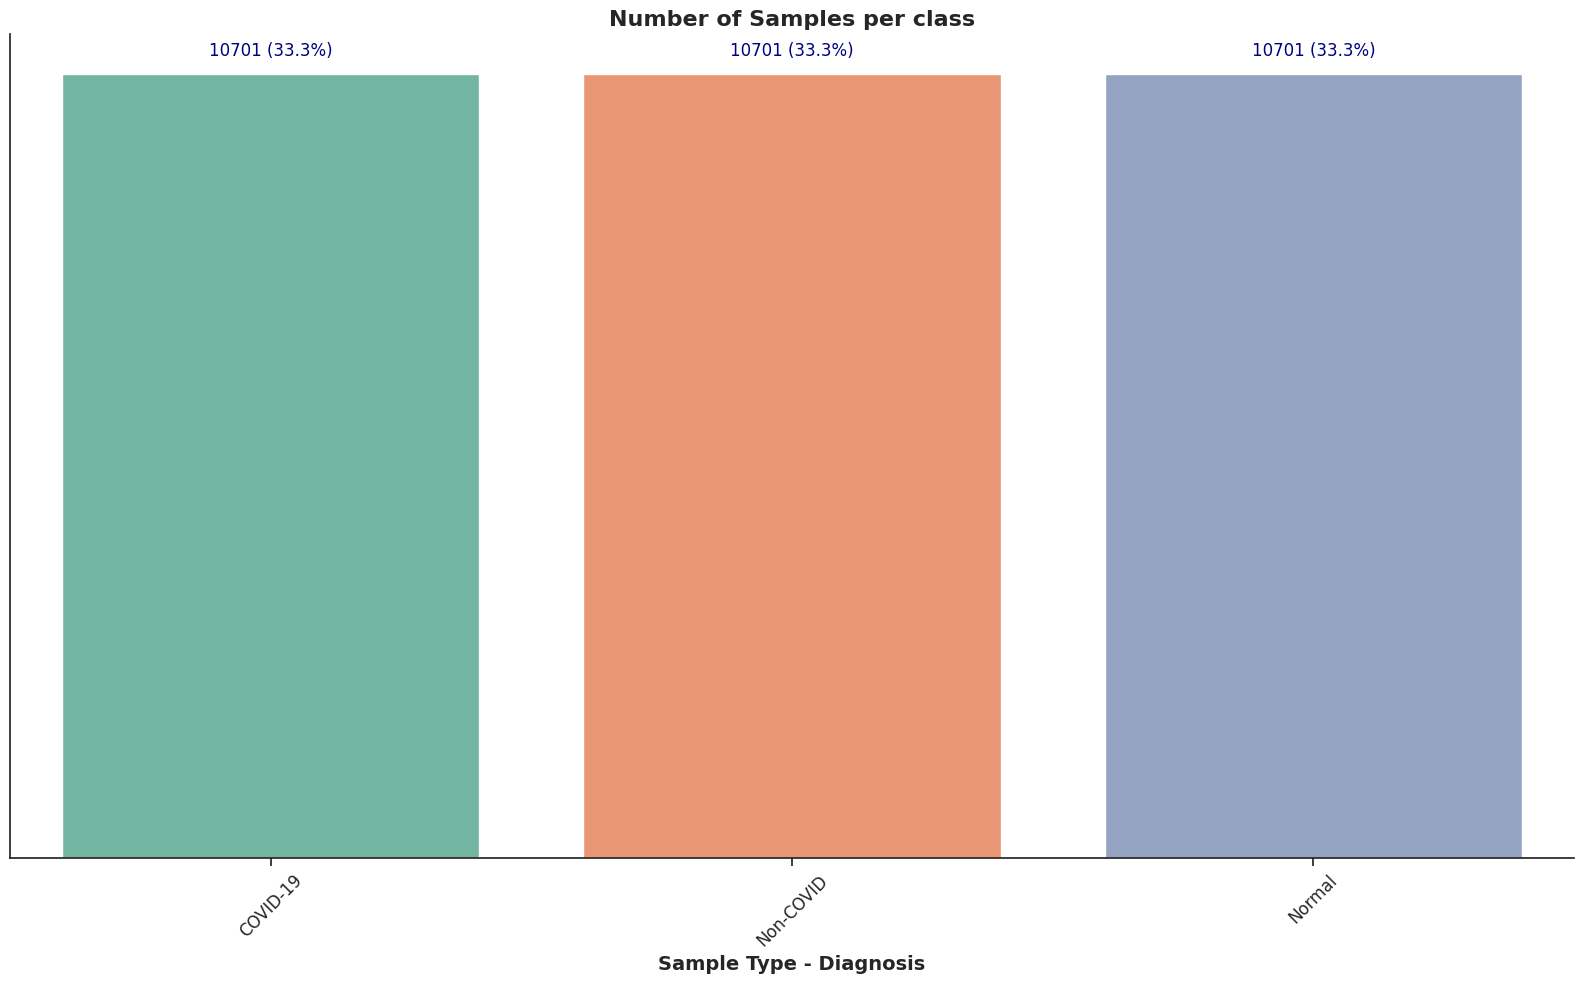

In [12]:
def plot_class_counts(df):
  """
  Plots the number of samples per class in the dataset.

  Parameters:
  - df: The DataFrame containing the dataset.
  """
  plt.figure(figsize=(16, 10))
  sns.set(style="ticks", font_scale=1)
  palette_new = "Set2"
  ax = sns.countplot(data=df, x='diag', order=df['diag'].value_counts().index, palette=palette_new)
  sns.despine(top=True, right=True, left=False, bottom=False)

  plt.xticks(rotation=45, fontsize=12)
  ax.set_xlabel('Sample Type - Diagnosis', fontsize=14, weight='bold')
  ax.set_ylabel('Count', fontsize=14, weight='bold')
  ax.set(yticklabels=[])
  ax.axes.get_yaxis().set_visible(False)

  plt.title('Number of Samples per class', fontsize=16, weight='bold')

  for p in ax.patches:
    height = int(p.get_height())
    percentage = 100 * (height / len(df))  # Use the total number of samples for percentage calculation
    text = f'{height} ({percentage:.1f}%)'
    ax.annotate(text,
          (p.get_x() + p.get_width() / 2., height),
          ha='center', va='bottom',
          color='navy',
          xytext=(0, 10),
          textcoords='offset points')

  plt.tight_layout()
  plt.show()

plot_class_counts(covidData)

In [13]:
def calculate_image_statistics(img_col):
    """
    Calculates basic statistics for the images in the dataset.

    Parameters:
    - img_col: The input column containing image data

    Returns:
    - Tuple containing calculated statistics: shape, width, height, min_value, max_value
    """
    # Calculate the shape, width, height, min_value, and max_value for each element in the image_column
    shape = img_col.apply(lambda x: x.shape)
    width = shape.apply(lambda x: x[0])
    height = shape.apply(lambda x: x[1])
    min_value = img_col.apply(lambda x: np.min(x))
    max_value = img_col.apply(lambda x: np.max(x))

    # Print the basic statistics
    print(f"Statistics for column: {img_col.name}")
    print(f"-----------------------------------")
    print(f"Width - Min: {width.min()}, Max: {width.max()}")
    print(f"Width - Mean: {width.mean():.2f}, Standard Deviation: {width.std():.2f}")
    print(f"Height - Min: {height.min()}, Max: {height.max()}")
    print(f"Height - Mean: {height.mean():.2f}, Standard Deviation: {height.std():.2f}")
    print(f"Min pixel value: {min_value.min()}, Max pixel value: {max_value.max()}")

    return shape, width, height, min_value, max_value

def run_checks(img_col, shape_target = (255,255), pixel_range=(0, 255)):
    """
    Runs basic checks on the images in the dataset.

    Parameters:
    - img_col: The input column containing image data
    - shape_target: The target shape for the images
    - pixel_range: The expected range for pixel values
    """
    shape, width, height, min_value, max_value = calculate_image_statistics(img_col)

    # Check if the images have the correct shape
    assert all(shape == shape_target), f"Shape check failed: {shape.unique()}"
    print()
    print(f"Shape check passed. Unique shapes: {shape.unique()}")

    # Check if the pixel values are within the expected range
    if pixel_range:
        assert all(min_value >= pixel_range[0]) and all(max_value <= pixel_range[1]), f"Pixel range check failed: {min_value.unique()}, {max_value.unique()}"
        print(f"Pixel range check passed. Unique min values: {min_value.unique()}, Unique max values: {max_value.unique()}")

In [14]:
# Example usage:
image_statistics = calculate_image_statistics(covidData['image'])
print()
mask_statistics = calculate_image_statistics(covidData['mask'])

Statistics for column: image
-----------------------------------
Width - Min: 255, Max: 255
Width - Mean: 255.00, Standard Deviation: 0.00
Height - Min: 255, Max: 255
Height - Mean: 255.00, Standard Deviation: 0.00
Min pixel value: 0, Max pixel value: 255

Statistics for column: mask
-----------------------------------
Width - Min: 255, Max: 255
Width - Mean: 255.00, Standard Deviation: 0.00
Height - Min: 255, Max: 255
Height - Mean: 255.00, Standard Deviation: 0.00
Min pixel value: 0, Max pixel value: 1


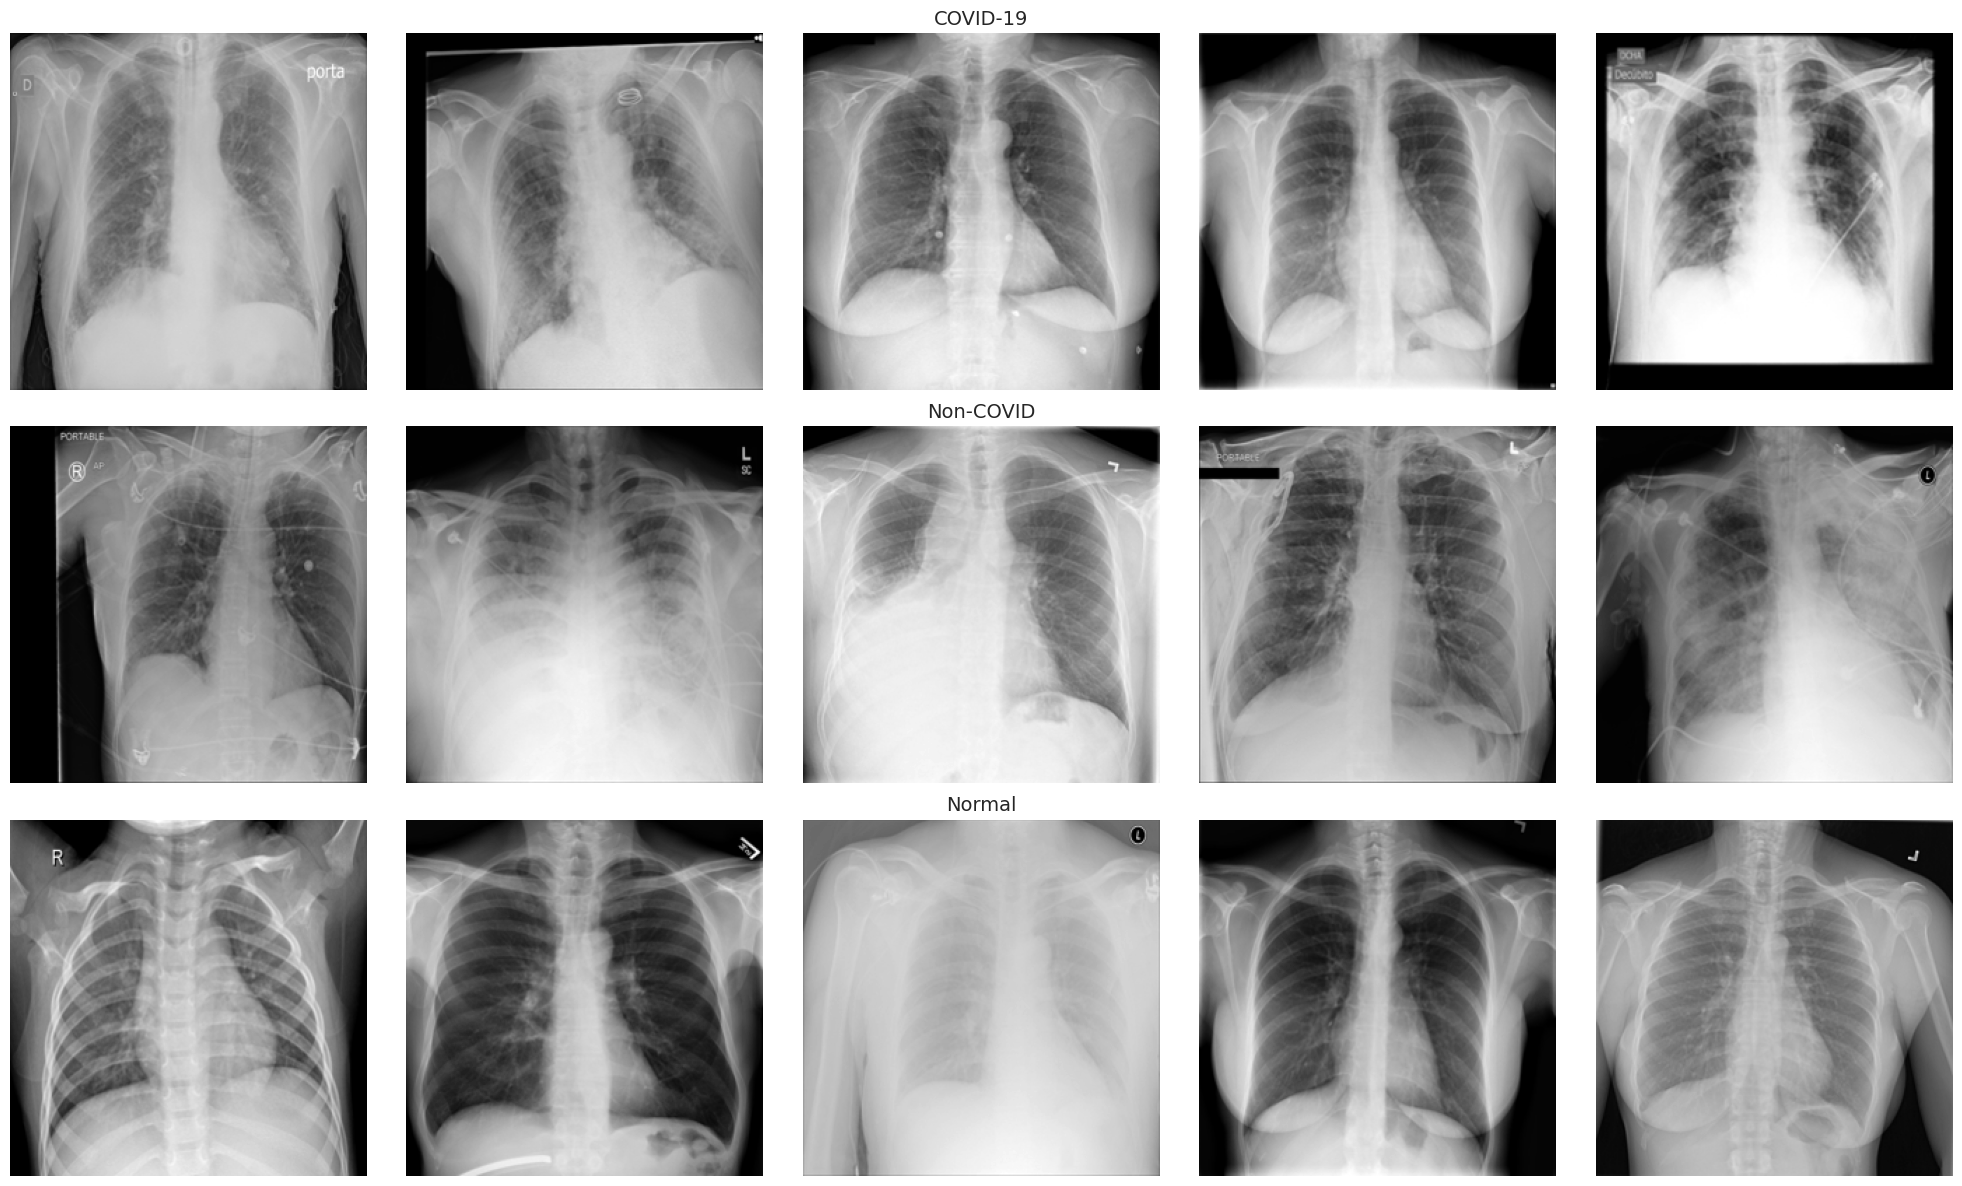

In [15]:
def plot_image_samples(df, n_samples=5, random_state=None):
    """
    Plots a number of random samples from each class in the dataset.

    Args:
        df (DataFrame): The DataFrame containing columns for 'diag' and 'image'.
        n_samples (int): The number of samples to plot for each class.
        random_state (int, optional): Random state for reproducibility.

    Returns:
        None. Displays a plot of image samples.
    """
    # Set up the figure with the appropriate number of subplots
    n_classes = df['diag'].nunique()
    fig, m_axs = plt.subplots(n_classes, n_samples, figsize=(4 * n_samples, 4 * n_classes))

    # Adjust for single row of axes to be iterable
    if n_classes == 1:
        m_axs = [m_axs]

    # Iterate through each class and its corresponding axes
    for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['diag']).groupby('diag')):
        # Set the title in the middle or just right of the middle axis depending on the parity of n_samples
        mid_col_index = n_samples // 2
        n_axs[mid_col_index].set_title(type_name, fontsize=14)

        # Sample the images and plot them
        for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=random_state).iterrows()):
            image = c_row['image']
            c_ax.imshow(image, cmap='gray')  # Assume images are grayscale
            c_ax.axis('off')

    plt.tight_layout()

plot_image_samples(covidData, 5, random_state=3)

In [16]:
def calculate_image_statistic_df(df, img_col='image'):
    """
    Creates a DataFrame with image statistics for each sample in the input DataFrame column

    Parameters:
    - df: The input DataFrame containing image data

    Returns:
    - A DataFrame containing image statistics for each sample
    """
    # Define a function to calculate statistics for a single image
    def calculate_image_stats(image):
        return {
            'mean': image.mean(),
            'std_dev': np.std(image),
            'max_val': image.max(),
            'min_val': image.min()
        }

    # Parallelize the computation of image statistics
    results = Parallel(n_jobs=-1)(
        delayed(calculate_image_stats)(image) for image in df[img_col]
    )

    # Extract the results
    stats = {
        'mean': [result['mean'] for result in results],
        'std_dev': [result['std_dev'] for result in results],
        'max_val': [result['max_val'] for result in results],
        'min_val': [result['min_val'] for result in results]
    }

    # Create a DataFrame with image statistics
    imageEDA = df[['filename', 'split', 'diag', 'image']].copy()
    imageEDA['mean'] = stats['mean']
    imageEDA['std_dev'] = stats['std_dev']
    imageEDA['max'] = stats['max_val']
    imageEDA['min'] = stats['min_val']

    # Subtract mean from each sample mean
    imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

    return imageEDA

# Usage:
imageEDA = calculate_image_statistic_df(covidData)

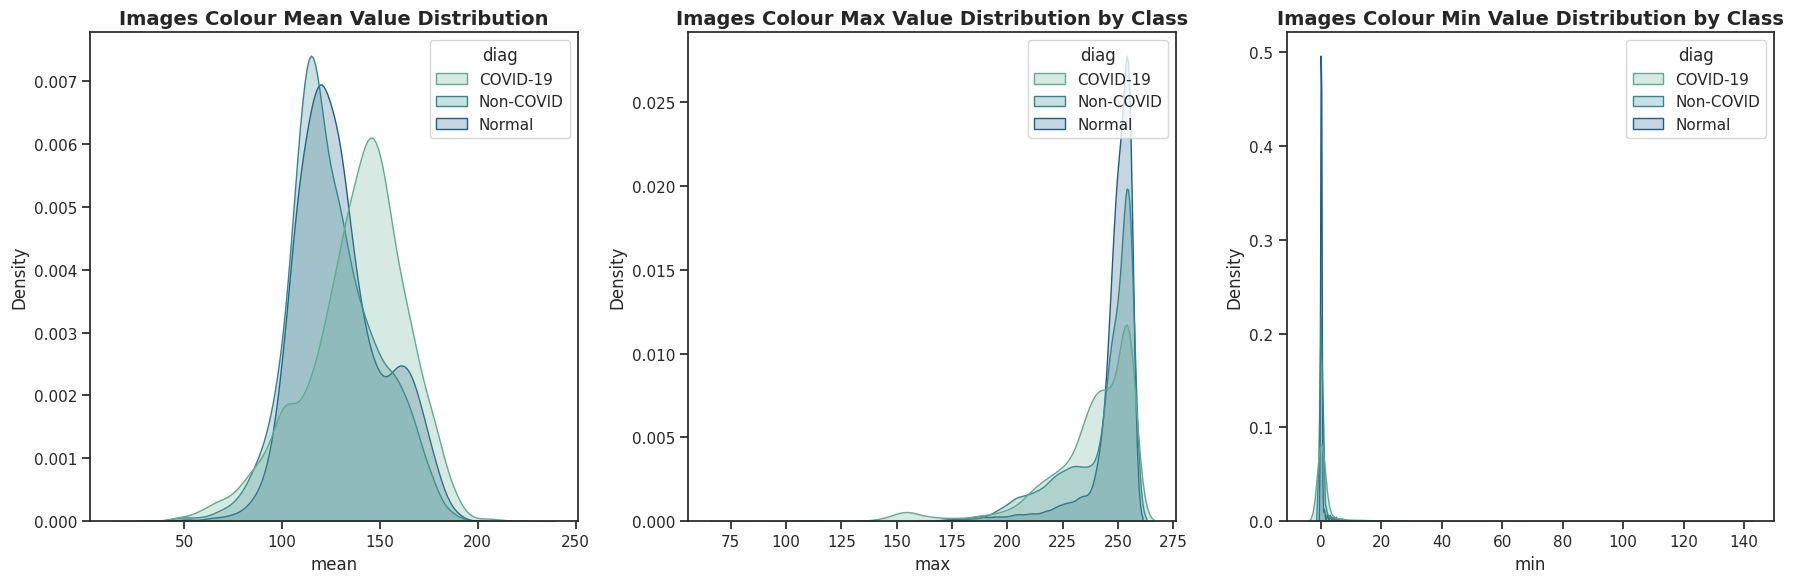

<Figure size 1800x600 with 0 Axes>

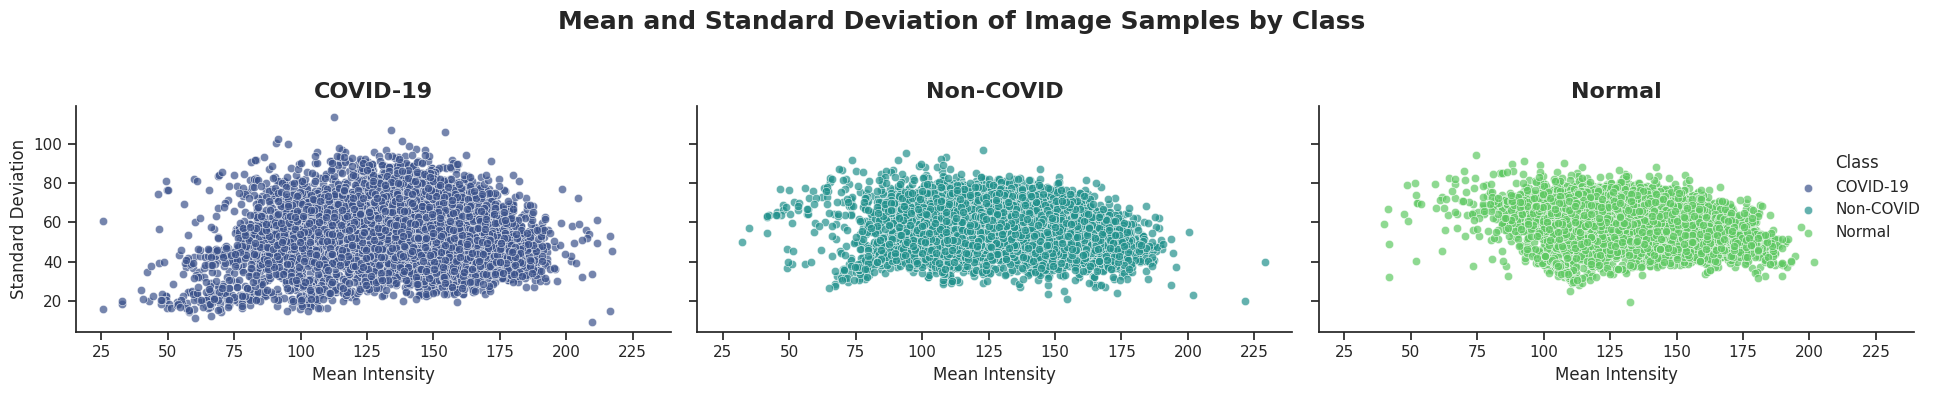

In [17]:
def plot_color_distributions(imageEDA):
    """Plots the mean, max, and min value distributions of images by class."""
    variables = ['mean', 'max', 'min']
    titles = [
        'Images Colour Mean Value Distribution',
        'Images Colour Max Value Distribution by Class',
        'Images Colour Min Value Distribution by Class'
    ]

    plt.figure(figsize=(18, 6))
    for i, (var, title) in enumerate(zip(variables, titles)):
        plt.subplot(1, 3, i+1)
        sns.kdeplot(data=imageEDA, x=var, hue='diag', fill=True, palette="crest")
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel(var, fontsize=12)
        plt.ylabel('Density', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_image_scatter(imageEDA):
    """Plot the mean and standard deviation of image samples by class."""
    plt.figure(figsize=(18, 6))
    g = sns.FacetGrid(imageEDA, col="diag", hue="diag", col_wrap=3, height=4, aspect=1.5, palette="viridis")
    g.map_dataframe(sns.scatterplot, 'mean', 'std_dev', alpha=0.7, edgecolor="w")

    g.set_titles("{col_name}", size=16, weight='bold')
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle('Mean and Standard Deviation of Image Samples by Class', fontsize=18, weight='bold')

    g.set_axis_labels("Mean Intensity", "Standard Deviation")
    g.add_legend(title="Class")

    g.fig.tight_layout(rect=[0, 0, 1, 0.95])

    plt.show()

plot_color_distributions(imageEDA)
plot_image_scatter(imageEDA)

# Preprocessing

In [18]:
covidData_processed = covidData.copy()

## Helper functions for preprocessing

In [19]:
def visualize_imgs_multicol(df, col_1='image', col_2='mask', n=5, random_seed=42):
    """
    Visualizes a number of random images from two columns of a DataFrame.

    Parameters:
    - df: The input DataFrame.
    - col_1: The name of the first column containing images (defaults to 'image')
    - col_2: The name of the second column containing images (defaults to 'mask')
    - n: The number of images to visualize.
    - random_seed: The random seed to use for shuffling the DataFrame.
    """
    # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)

    fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
    for i in range(n):
        axes[0, i].imshow(df.iloc[i][col_1], cmap='gray')
        axes[0, i].set_title(f'{col_1} {i+1}')
        axes[1, i].imshow(df.iloc[i][col_2], cmap='gray')
        axes[1, i].set_title(f'{col_2} {i+1}')

    plt.tight_layout()
    plt.show()

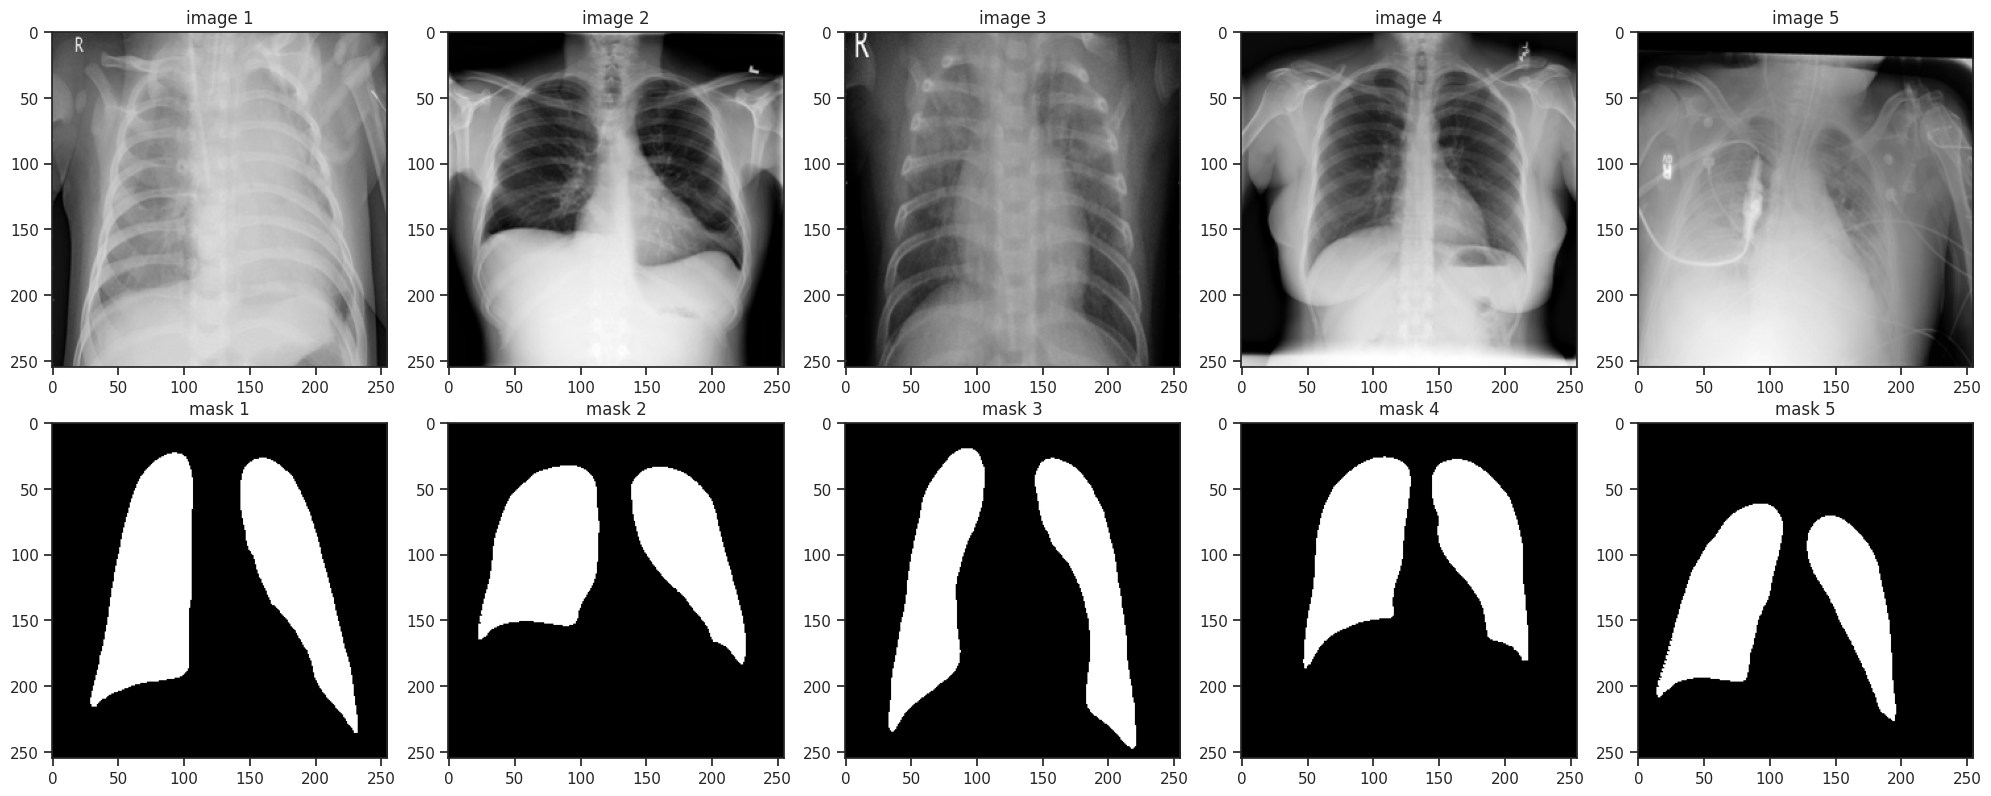

In [20]:
visualize_imgs_multicol(covidData)

## Normalize greyscale

In [21]:
def normalize_greyscale(row, input_col, range=(0, 255)):
    """
    Normalizes the greyscale values of an image to the specified range.

    Parameters:
    - row: The input row containing the image data.
    - input_col: The name of the input column containing the image data to be normalized.

    Returns:
    - The normalized image array.
    """
    img = row[input_col]
    img = img.astype(np.float32)
    mean = np.mean(img)
    std = np.std(img)
    normalized_image = (img - mean) / std
    return normalized_image

In [22]:
covidData_processed['image_n'] = covidData_processed.apply(lambda row: normalize_greyscale(row, 'image'), axis=1)

In [27]:
run_checks(covidData_processed['image_n'], pixel_range=(-20,20))

Statistics for column: image_n
-----------------------------------
Width - Min: 255, Max: 255
Width - Mean: 255.00, Standard Deviation: 0.00
Height - Min: 255, Max: 255
Height - Mean: 255.00, Standard Deviation: 0.00
Min pixel value: -22.796730041503906, Max pixel value: 17.583688735961914

Shape check passed. Unique shapes: [(255, 255)]


AssertionError: Pixel range check failed: [-2.1364672 -2.8300307 -2.6552873 ... -2.229959  -2.0155096 -1.7178439], [1.9147927 1.7410872 1.2685764 ... 1.5460787 1.636145  1.9815814]

In [ ]:
visualize_imgs_multicol(covidData_processed, col_1='image', col_2='image_n', n=20, random_seed=1)

In [ ]:
covidData_processed.head()

,filename,diag,split,image,mask,image_n
0,covid_2824.png,COVID-19,test,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-2.1364672, -2.1364672, -2.1364672, -2.13646..."
1,covid_2788.png,COVID-19,test,"[[26, 16, 9, 7, 7, 6, 6, 6, 7, 8, 8, 8, 8, 8, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-2.3242898, -2.5188055, -2.6549666, -2.69386..."
2,sub-S09387_ses-E16189_acq-1_run-1_bp-chest_vp-...,COVID-19,test,"[[31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-2.1782684, -2.6552873, -2.6552873, -2.65528..."
3,sub-S12286_ses-E26834_run-1_bp-chest_vp-pa_dx.png,COVID-19,test,"[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-2.3495054, -2.3495054, -2.3495054, -2.34950..."
4,sub-S12362_ses-E24730_run-1_bp-chest_dx.png,COVID-19,test,"[[61, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.8755346, -0.9212822, -0.9212822, -0.92128..."


## Crop image and mask

In [ ]:
def crop_image_and_mask(image_array, mask_array, output_size=(255, 255), padding=0):
    """
    Crop the input image and mask based on the non-black area of the mask. Dynamically adjust padding
    to ensure it does not exceed the image boundaries.

    Parameters:
    - image_array (numpy.ndarray): The input image array.
    - mask_array (numpy.ndarray): The mask array indicating the region of interest.
    - output_size (tuple): The desired output size of the cropped image and mask. Defaults to (255, 255).
    - padding (int): The initial number of additional pixels to add around the mask coordinates,
                     both horizontally and vertically.

    Returns:
    - tuple: A tuple containing the resized cropped image and mask.
    """
    # Convert mask to binary
    _, mask_binary = cv2.threshold(mask_array, 0, 1, cv2.THRESH_BINARY)

    # Crop image and mask based on the mask's non-black area
    coords = cv2.findNonZero(mask_binary)  # Find all non-black pixels in the mask
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)  # Find bounding box of those pixels

        # Dynamically adjust padding based on image boundaries
        padding_x = min(padding, x, image_array.shape[1] - (x + w))
        padding_y = min(padding, y, image_array.shape[0] - (y + h))

        # Apply adjusted padding
        x = x - padding_x
        y = y - padding_y
        w = w + 2 * padding_x
        h = h + 2 * padding_y

        image_cropped = image_array[y:y+h, x:x+w]
        mask_cropped = mask_binary[y:y+h, x:x+w]
    else:
        image_cropped = image_array
        mask_cropped = mask_binary

    # Resize cropped image and mask
    image_resized = cv2.resize(image_cropped, output_size, interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(mask_cropped, output_size, interpolation=cv2.INTER_AREA)

    return image_resized, mask_resized

def apply_cropping(row, img_col, mask_col, padding=0):
    """
    Creates a pandas Series containing the cropped image and mask.

    Parameters:
    - row: The input row containing the image and mask data.
    - img_col: The name of the column containing the image data.
    - mask_col: The name of the column containing the mask data.
    - padding: The number of additional pixels to add around the mask coordinates, both horizontally and vertically.

    Returns:
    - pd.Series: A pandas Series containing the cropped image and mask.
    """
    cropped_image, cropped_mask = crop_image_and_mask(row[img_col], row[mask_col], padding=padding)
    return pd.Series([cropped_image, cropped_mask], index=['image_cropped', 'mask_cropped'])

In [ ]:
covidData_processed[['image_n_c', 'mask_c']] = covidData_processed.apply(
    lambda row: apply_cropping(row, 'image_n', 'mask', 10), axis=1
)

In [ ]:
run_checks(covidData_processed['image_n_c'], shape_target=(255, 255), pixel_range=None)
print()
run_checks(covidData_processed['mask_c'], shape_target=(255, 255), pixel_range=(0, 1))

In [ ]:
# Visualize the cropped images and masks
visualize_imgs_multicol(covidData_processed, col_1='image_n', col_2='image_n_c', n=10, random_seed=3)

In [ ]:
# Visualize the cropped images and masks
visualize_imgs_multicol(covidData_processed, col_1='image_n_c', col_2='mask_c', n=10, random_seed=3)

## Align images

In [ ]:
def align_image(image, mask):
    """
    Aligns the input image and mask with the horizontal axis.

    Parameters:
    - image_array (numpy.ndarray): The input image array.
    - mask_array (numpy.ndarray): The mask array indicating the region of interest.
    """
    # Convert image to grayscale if it is not already
    # if len(image.shape) == 3 and image.shape[2] == 3:
    #     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # else:
    #     gray = image.copy()
    # gray = np.uint8(gray)

    gray = np.uint8(image)

    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    if lines is not None:
        for rho, theta in lines[0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))

            # Calculate angle with respect to the horizontal axis
            angle = np.arctan2(y2 - y1, x2 - x1) * 180. / np.pi

            # Rotate image and mask to align with the horizontal axis
            image_center = tuple(np.array(image.shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
            aligned_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
            aligned_mask = cv2.warpAffine(mask, rot_mat, mask.shape[1::-1], flags=cv2.INTER_LINEAR)

            return aligned_image, aligned_mask

    return image, mask

def apply_alignment(row, img_col, mask_col):
    """
    Creates a pandas Series containing the aligned image and mask.

    Parameters:
    - row: The input row containing the image and mask data.
    - img_col: The name of the column containing the image data.
    - mask_col: The name of the column containing the mask data.

    Returns:
    - pd.Series: A pandas Series containing the aligned image and mask.
    """
    aligned_image, aligned_mask = align_image(row[img_col], row[mask_col])
    return pd.Series([aligned_image, aligned_mask], index=['image_aligned', 'mask_aligned'])

In [ ]:
covidData_processed[['image_n_c_a', 'mask_c_a']] = covidData_processed.apply(
    lambda row: apply_alignment(row, 'image_n_c', 'mask_c'), axis=1
)

In [ ]:
run_checks(covidData_processed['image_n_c_a'], shape_target=(255, 255), pixel_range=None)
print()
run_checks(covidData_processed['mask_c_a'], shape_target=(255, 255), pixel_range=(0, 1))

In [ ]:
# Visualize the cropped images and masks
visualize_imgs_multicol(covidData_processed, col_1='image_n_c', col_2='image_n_c_a', n=25, random_seed=3)

## Apply rotation

In [ ]:
def rotate_image_to_make_line_perpendicular(image, mask):
    """
    Rotates the given image and mask to make the line perpendicular.

    Parameters:
    image (numpy.ndarray): The input image.
    mask (numpy.ndarray): The mask corresponding to the image.

    Returns:
    numpy.ndarray: The rotated image.
    numpy.ndarray: The rotated mask.
    """
    edit_image = np.uint8(image)
    edit_mask = np.uint8(mask)

    ret,thresh = cv2.threshold(edit_image,255,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)

    if not contours:
        return image, mask
    cnt = contours[0]

    cnt = max(contours, key=cv2.contourArea)
    [vx, vy, x, y] = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
    angle = np.arctan2(vy, vx) * 180 / np.pi
    rotation_angle = angle - 90

    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation_angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))
    rotated_mask = cv2.warpAffine(mask, M, (cols, rows))

    # Debug prints
    print("Rotation angle:", rotation_angle)
    print("Original shape:", image.shape)
    print("Rotated shape:", rotated_image.shape)

    return rotated_image, rotated_mask

def apply_rotation(row, img_col, mask_col):
    """
    Creates a pandas Series containing the rotated image and mask.

    Parameters:
    - row: The input row containing the image and mask data.
    - img_col: The name of the column containing the image data.
    - mask_col: The name of the column containing the mask data.

    Returns:
    - pd.Series: A pandas Series containing the rotated image and mask.
    """
    rotated_image, rotated_mask = rotate_image_to_make_line_perpendicular(row[img_col], row[mask_col])
    return pd.Series([rotated_image, rotated_mask], index=['image_rotated', 'mask_rotated'])

In [ ]:
covidData_processed[['image_n_c_a_r', 'mask_c_a_r']] = covidData_processed.apply(
    lambda row: apply_rotation(row, 'image_n_c_a', 'mask_c_a'), axis=1
)

In [ ]:
run_checks(covidData_processed['image_n_c_a_r'], shape_target=(255, 255), pixel_range=None)
print()
run_checks(covidData_processed['mask_c_a_r'], shape_target=(255, 255), pixel_range=(0, 1))

visualize_imgs_multicol(covidData_processed, col_1='image', col_2='image_n_c_a_r', n=20, random_seed=1)

# Remove unnecessary columns

In [ ]:
covidData_processed.head()

In [ ]:
# Cols to keep
cols_to_keep = ['filename', 'diag', 'split', 'image_n', 'mask', 'image_n_c_a_r', 'mask_c_a_r']
covidData_processed = covidData_processed[cols_to_keep]

# Rename columns
covidData_processed.rename(columns={
    'image_n': 'image_normalized',
    'mask': 'mask_original',
    'image_n_c_a_r': 'image_processed',
    'mask_c_a_r': 'mask_processed'
    }, inplace=True)

In [ ]:
covidData_processed.info(memory_usage='deep')

# Export data

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Save the dataframe as a pickle file
covidData_processed.to_pickle('drive/MyDrive/PneumoniaCXR-AIDetect/data/processed/covid_data_full.pkl', compression='gzip')

# Subsample and export subsampled data

In [ ]:
def create_subsampled_df(df, pct_sample, random_state=RANDOM_SEED):
    """
    Subsample the dataframe, drawing a given percentage from each diagnostic category and split.

    Parameters:
    - df: pandas.DataFrame, the original dataframe
    - pct_sample: float, the percentage of samples to draw from each category
    - random_state: int, the random seed for reproducibility

    Returns:
    - df_subsampled: pandas.DataFrame, the subsampled dataframe
    """
    # Ensure sample percentage is between 0 and 1
    if pct_sample < 0 or pct_sample > 1:
        raise ValueError('n_samples must be between 0 and 1')

    # Shuffle the dataframe with a random seed
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Calculate the number of samples to draw based on the percentage
    def samples_to_draw(x):
        num_samples = round(len(x) * (pct_sample))
        return x.sample(max(num_samples, 1), random_state=random_state) # Ensuring at least 1 sample

    df_subsampled = df.groupby(['diag', 'split'], group_keys=False).apply(samples_to_draw).reset_index(drop=True)

    return df_subsampled

In [ ]:
covidData_processed_subset = create_subsampled_df(covidData_processed, pct_sample=0.1, random_state=RANDOM_SEED)
covidData_processed_subset.to_pickle('drive/MyDrive/PneumoniaCXR-AIDetect/data/processed/covid_data_subset.pkl', compression='gzip')